# Week 02 | Homework 1:  Median Blurring in $O(1)$ Runtime Complexity

> Reference:   
https://files-cdn.cnblogs.com/files/Imageshop/MedianFilterinConstantTime.pdf

In [0]:
import numpy as np

In [0]:
image = np.random.randint(low=0, high=255, size=(7, 11)).astype(np.uint8)
print(image)
H, W = image.shape

[[242 215 122   1 139  99 191 130   4 246 217]
 [244  53  92 136  74 215 181 199 192  82 137]
 [131 240 160 202 150  15  44  92 204  43  26]
 [ 25 233 173 220 140 176   8 101 123   7 133]
 [ 96 226 177 200 158 196 235 152 196  84  79]
 [254 244 137 248  77  27 109  84 204   5 116]
 [209 211 193 206  19 144  23  62  89 114 152]]


## I. 功能函数

In [0]:
padding_ways = ["REPLICA", "ZERO"]
padding_way = np.random.choice(padding_ways, 1)
print(padding_way)

['REPLICA']


In [0]:
print(np.pad(image, pad_width=1, mode='constant', constant_values=0))
print('\n', np.pad(image, pad_width=1, mode='edge'))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 242 215 122   1 139  99 191 130   4 246 217   0]
 [  0 244  53  92 136  74 215 181 199 192  82 137   0]
 [  0 131 240 160 202 150  15  44  92 204  43  26   0]
 [  0  25 233 173 220 140 176   8 101 123   7 133   0]
 [  0  96 226 177 200 158 196 235 152 196  84  79   0]
 [  0 254 244 137 248  77  27 109  84 204   5 116   0]
 [  0 209 211 193 206  19 144  23  62  89 114 152   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]

 [[242 242 215 122   1 139  99 191 130   4 246 217 217]
 [242 242 215 122   1 139  99 191 130   4 246 217 217]
 [244 244  53  92 136  74 215 181 199 192  82 137 137]
 [131 131 240 160 202 150  15  44  92 204  43  26  26]
 [ 25  25 233 173 220 140 176   8 101 123   7 133 133]
 [ 96  96 226 177 200 158 196 235 152 196  84  79  79]
 [254 254 244 137 248  77  27 109  84 204   5 116 116]
 [209 209 211 193 206  19 144  23  62  89 114 152 152]
 [209 209 211 193 206  19 144  23  62  89 114 152 152]]


In [0]:
r = 1  # kernel半径
if padding_way == "ZERO":
  img = np.pad(image, pad_width=r, mode='constant', constant_values=0)
else:
  img = np.pad(image, pad_width=r, mode='edge')

### 0. 定义padding函数

In [0]:
def get_padding_img(image, r, padding_way='ZEROS'):
  assert padding_way in ["REPLICA", "ZERO"]
  if padding_way == "ZERO":
    img = np.pad(image, pad_width=r, mode='constant', constant_values=0)
  else:
    img = np.pad(image, pad_width=r, mode='edge')
  return img

### 1. 定义get_hist函数

In [0]:
def get_hist(j):
  col = img[0:(2*r+1), j]
  hist = np.zeros(256, dtype=np.uint8)
  for val in col:
    hist[val] += 1 
  return hist

In [0]:
# test:
print(img[0:(2*r+1), 2])
print(get_hist(2)[215], get_hist(2)[53])

[215 215  53]
2 1


### 2. 初始化第一行

In [0]:
# 创建空矩阵
h_hist = np.zeros((256, W+2*r), dtype=np.uint8)  # 记录包括padding在内的每一列；统计的每个小column只有2*r+1维，为了可加，同一到256维。
H_hist = np.zeros((256, 2*r+1), dtype=np.uint8)  # 记录当前kernel所在位置的每一列
global h_hist
global H_hist

In [0]:
# 初始化H_hist和h_hist:
for j in range(W+2*r):
  hist = get_hist(j)
  h_hist[:, j] = hist
  if j < 2 * r + 1:
    H_hist[:, j] = hist

In [0]:
# test H_hist:
print(img[:2 * r + 1, :2 * r + 1])
print(H_hist[242, 0], H_hist[244, 0])
print(H_hist[215, 2], H_hist[53, 2])

[[242 242 215]
 [242 242 215]
 [244 244  53]]
2 1
2 1


In [0]:
#test h_hist:
print(img[:2*r+1, 10:12])
print(h_hist[246,10],h_hist[137,11])

[[246 217]
 [246 217]
 [ 82 137]]
2 1


### 3. 定义位移函数：move_down()，move_right()

### \# The two steps of the Constant Time Median Filtering algorithm.
![The two steps of the Constant Time Median Filtering algorithm.](https://drive.google.com/uc?id=1ftY3gxP7OcKAmq3WlckG96B7TI0m_vxY)

In [0]:
# First!
# update h_hist:
def move_down(i, j_move):
  # i is the line of current central pixel in padded-image img;
  # j_move is the list of columns to be moved in h_hist.
  i_remove = i - r -1
  i_add = i + r
  if isinstance(j_move, int):
    j_move = [j_move, ]
  for j in j_move:
    remove_val = img[i_remove, j]
    add_val = img[i_add, j]
    h_hist[remove_val, j] -= 1
    h_hist[add_val, j] += 1

In [0]:
# Second!
# update H_hist:
def move_right(H_hist, j_h):
  # j_h is the column of current central pixel in h_hist.
  # 注意: 此时的H_hist尚未更新,还处于上一个位置;但j已经更新,是当前位置的列.
  # j_remove = j_h - r - 1是相对于h_hist来说的,事实上H_hist永远只需要del第0列.
  j_add = j_h + r
  H_hist = np.c_[np.delete(H_hist, 0, axis=1), 
                 h_hist[:, j_add]]
  return H_hist

>没有测试，因为位移函数是直接在全局变量h_hist和H_hist上进行更新的。

### 4. 定义求中值函数：get_median()

In [0]:
def get_median():
  # get median value for current H_hist
  hist = np.sum(H_hist, axis=1)
  thres = (2 * r + 1) ** 2 // 2 + 1
  sum = 0
  for val in range(256):
    cnt = hist[val]
    sum += cnt
    if sum >= thres:
      break
  median = val
  return median

In [0]:
# test
print(np.sort(img[:2 * r + 1, :2 * r + 1].ravel()))
get_median()

[ 53 215 215 242 242 242 242 244 244]


242

## II. 主循环

In [0]:
median_image = np.zeros(image.shape, dtype=np.uint8)

### 1.初始化H_hist和h_hist;
### 2.h_hist计算首行median并填充; 事实上H_hist没必要单独初始化,随计算一起即可.

In [0]:
i = 0
for j in range(W):
  # current j corresponding to j+r in h_hist.
  j_h = j + r
  H_hist = h_hist[:, j_h-r: j_h+r + 1]
  median_image[i, j] = get_median()

In [0]:
print(median_image)

[[242 215 122 122  99 139 181 181 130 192 217]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]


### 3. 计算次行至末行median并填充; 每行首个元素单独处理.

In [0]:
# (i, j) is the position of current central pixel in image.
# first line processed separately
for i in range(1, H):  
  for j in range(W):
    i_img = i + r  # current i corresponding to i+r in padded-image img   
    j_h = j + r  # current j corresponding to j+r in h_hist
    # 1.update h_hist and H_hist:
    if j == 0:
      # first element of each line processed separately
      j_move_down = list(range(j_h - r, j_h + r + 1))  # (2*r+1) columns in total. 
      move_down(i_img, j_move_down)  # first (2*r+1) columns of h_hist updated.
      H_hist = h_hist[:, j_h-r : j_h+r + 1]  # H_hist updated.
    else:
      j_move_down = j_h + r
      move_down(i_img, j_move_down)  # next one column in h_hist updated.
      H_hist = move_right(H_hist, j_h)  # H_hist updated.
    # 2.use updated H_hist to get median value to update median_image:
    median_image[i, j] = get_median()

In [0]:
print(median_image)
print(median_image.shape)

[[242 215 122 122  99 139 181 181 130 192 217]
 [240 160 136 136 136 139 130 181 130 137 137]
 [131 160 173 150 150 140 101 123 101 123  82]
 [131 173 202 173 176 150 101 123 101  84  79]
 [226 177 220 173 176 140 109 123 101 116  84]
 [211 209 206 177 158 109 109 109  89 114 114]
 [211 209 206 193 144  27  62  84  89 114 116]]
(7, 11)


## III. 类实现

In [0]:
class medianBlur():
    def __init__(self, image, r, padding_way):
        self.image = image
        self.r = r
        self.padding_way = padding_way
        self.H, self.W = image.shape
        self.img = self.get_padding_img()
        self.median_blur_image = np.zeros(image.shape, dtype=np.uint8)
        """
        初始化第一行:
        """
        """ (1) 创建空矩阵: """
        # 记录包括padding在内的每一列;
        # 统计的每个小column只有2*r+1维, 为了可加, 同一到256维:
        self.h_hist = np.zeros((256, self.W+2*r), dtype=np.uint8)
        # 记录当前kernel所在位置的每一列:
        self.H_hist = np.zeros((256, 2*r+1), dtype=np.uint8)
        """ (2) 初始化h_hist: """
        for j in range(self.W + 2 * r):
            self.h_hist[:, j] = self.get_hist(j)

    def get_median_image(self):
        r = self.r
        # (i, j) is the position of current central pixel in image.
        for i in range(self.H):
            for j in range(self.W):
                i_img = i + r  # current i corresponding to i+r in padded-image img
                j_h = j + r  # current j corresponding to j+r in h_hist
                """ 1.Update h_hist and H_hist: """
                if i == 0:  # first line processed separately
                    self.H_hist = self.h_hist[:, j_h - r: j_h + r + 1]
                else:
                    if j == 0:  # first element of each line processed separately
                        j_move_down = list(range(j_h - r, j_h + r + 1))  # (2*r+1) columns in total.
                        self.move_down(i_img, j_move_down)  # first (2*r+1) columns of h_hist updated.
                        self.H_hist = self.h_hist[:, j_h - r: j_h + r + 1]  # H_hist updated.
                    else:
                        j_move_down = j_h + r
                        self.move_down(i_img, j_move_down)  # next one column in h_hist updated.
                        self.move_right(j_h)  # H_hist updated.

                """ 2.Use updated H_hist to get median value to update median_image: """
                self.median_blur_image[i, j] = self.get_median()

    """
    0. 定义padding函数
    """
    def get_padding_img(self):
        assert self.padding_way in ["REPLICA", "ZERO"]
        if self.padding_way == "ZERO":
            img = np.pad(self.image, pad_width=self.r, mode='constant', constant_values=0)
        else:
            img = np.pad(self.image, pad_width=self.r, mode='edge')
        return img

    """
    1. 定义get_hist函数
    """
    def get_hist(self, j):
        col = self.img[0:(2 * self.r + 1), j]
        hist = np.zeros(256, dtype=np.uint8)
        for val in col:
            hist[val] += 1
        return hist

    """
    2. 定义位移函数: move_down(), move_right()
    """
    # First！
    # update h_hist:
    def move_down(self, i, j_move):
        # i is the line of current central pixel in padded-image img;
        # j_move is the list of columns to be moved in h_hist.
        i_remove = i - self.r - 1
        i_add = i + self.r
        if isinstance(j_move, int):
            j_move = [j_move, ]
        for j in j_move:
            remove_val = self.img[i_remove, j]
            add_val = self.img[i_add, j]
            self.h_hist[remove_val, j] -= 1
            self.h_hist[add_val, j] += 1

    # Second!
    # update H_hist:
    def move_right(self, j_h):
        # j_h is the column of current central pixel in h_hist.
        # 注意: 此时的H_hist尚未更新,还处于上一个位置;但j已经更新,是当前位置的列.
        # j_remove = j_h - r - 1是相对于h_hist来说的,事实上H_hist永远只需要del第0列.
        j_add = j_h + self.r
        self.H_hist = np.c_[np.delete(self.H_hist, 0, axis=1),
                            self.h_hist[:, j_add]]

    """
    3. 定义求中值函数: get_median()
    """
    def get_median(self):
        # get median value for current H_hist
        hist = np.sum(self.H_hist, axis=1)
        thres = (2 * self.r + 1) ** 2 // 2 + 1
        sum_cnt = 0
        median = 0
        for val in range(256):
            cnt = hist[val]
            sum_cnt += cnt
            if sum_cnt >= thres:
                median = val
                break
        return median

In [0]:
MB = medianBlur(image=image, r=1, padding_way=padding_way)
MB.get_median_image()
medianBlur_image = MB.median_blur_image
print(medianBlur_image)

[[242 215 122 122  99 139 181 181 130 192 217]
 [240 160 136 136 136 139 130 181 130 137 137]
 [131 160 173 150 150 140 101 123 101 123  82]
 [131 173 202 173 176 150 101 123 101  84  79]
 [226 177 220 173 176 140 109 123 101 116  84]
 [211 209 206 177 158 109 109 109  89 114 114]
 [211 209 206 193 144  27  62  84  89 114 116]]


## IV. Test

In [0]:
import os
import cv2
from skimage import io
from google.colab.patches import cv2_imshow

### 今天去了游乐园呢~ 耶✌~~

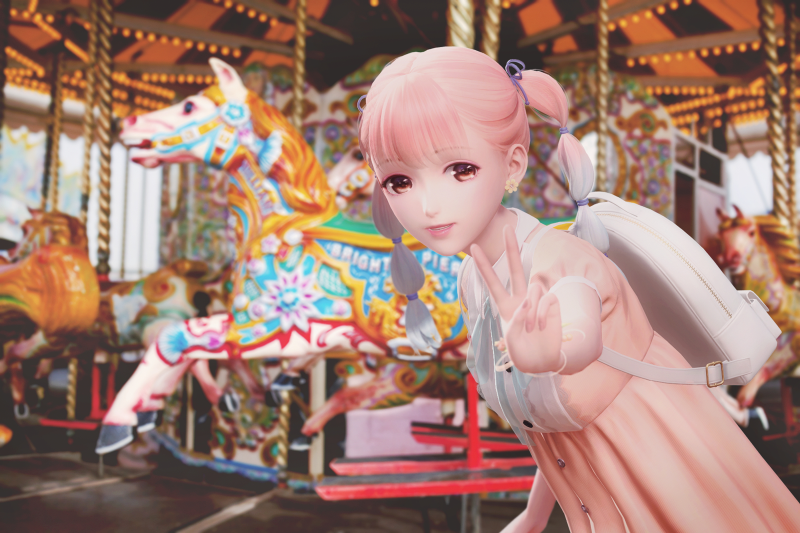

In [0]:
image_address = 'https://drive.google.com/uc?id=1Io3BqBdhyYQDs5rB5bzJ4bXV_by-BaGG'
image = cv2.cvtColor(io.imread(image_address).astype(np.uint8), cv2.COLOR_RGB2BGR)
img = cv2.resize(image, dsize=(int(image.shape[1]/2), int(image.shape[0]/2)))
cv2_imshow(img)

In [0]:
H, W, C = img.shape
print(H, W, C)
B, G, R = cv2.split(img)

533 800 3


In [0]:
def mb_func(img, r, padding_way):
  MB = medianBlur(image=img, r=r, padding_way=padding_way)
  MB.get_median_image()
  return MB.median_blur_image

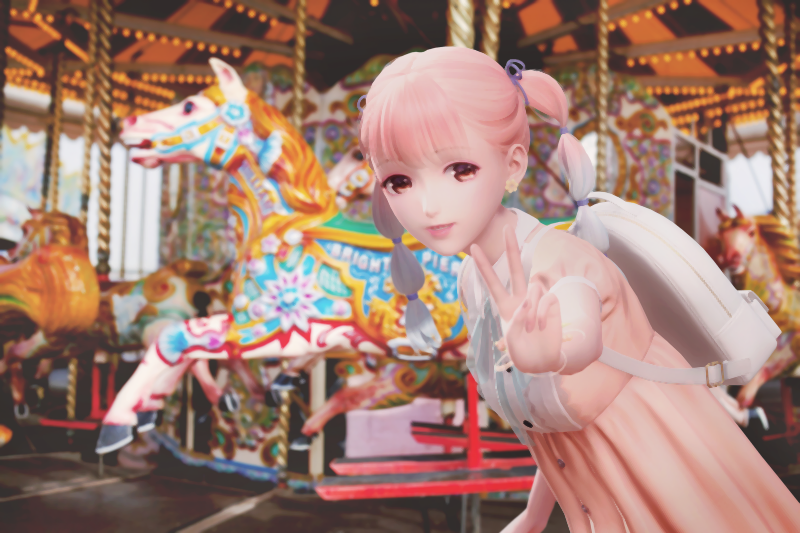

In [0]:
# Radius: r = 1
# kernel size = 2 * r + 1 = 3
r = 1
padding_way="REPLICA"

bgr_3 = list(map(lambda _: mb_func(_, r, padding_way), 
                 [B, G, R]))
mb_img_3 = cv2.merge(bgr_3)
cv2_imshow(mb_img_3)

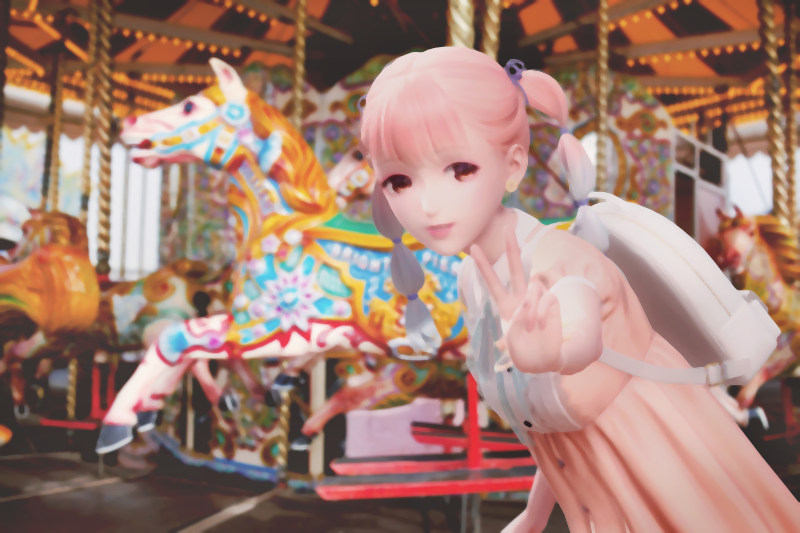

In [0]:
# Radius: r = 2
# kernel size = 2 * r + 1 = 5
bgr_5 = []
for _ in [B, G, R]:
  MB = medianBlur(image=_, r=2, padding_way="REPLICA")
  MB.get_median_image()
  bgr_5.append(MB.median_blur_image)

mb_img_5 = cv2.merge(bgr_5)
cv2_imshow(mb_img_5)

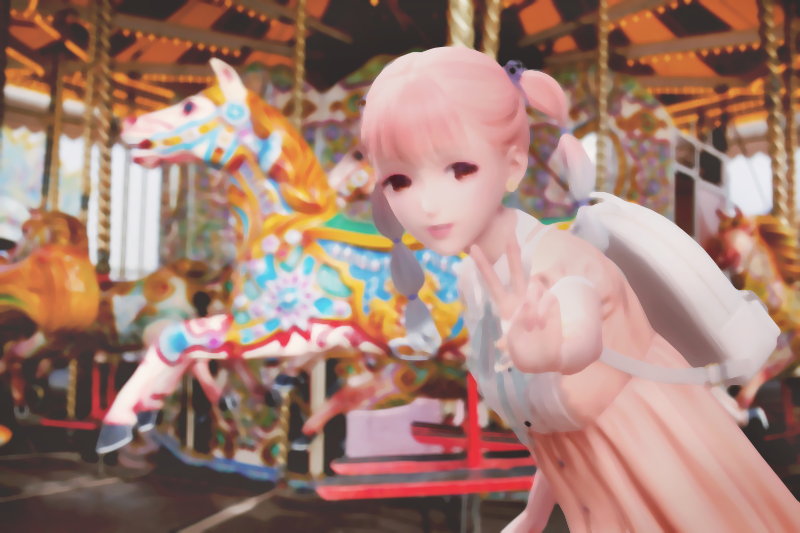

In [0]:
# Radius: r = 3
# kernel size = 2 * r + 1 = 7
bgr_7 = []
for _ in [B, G, R]:
  MB = medianBlur(image=_, r=3, padding_way="REPLICA")
  MB.get_median_image()
  bgr_7.append(MB.median_blur_image)

mb_img_7 = cv2.merge(bgr_7)
cv2_imshow(mb_img_7)

### 比较一下不同kernel size的处理效果~

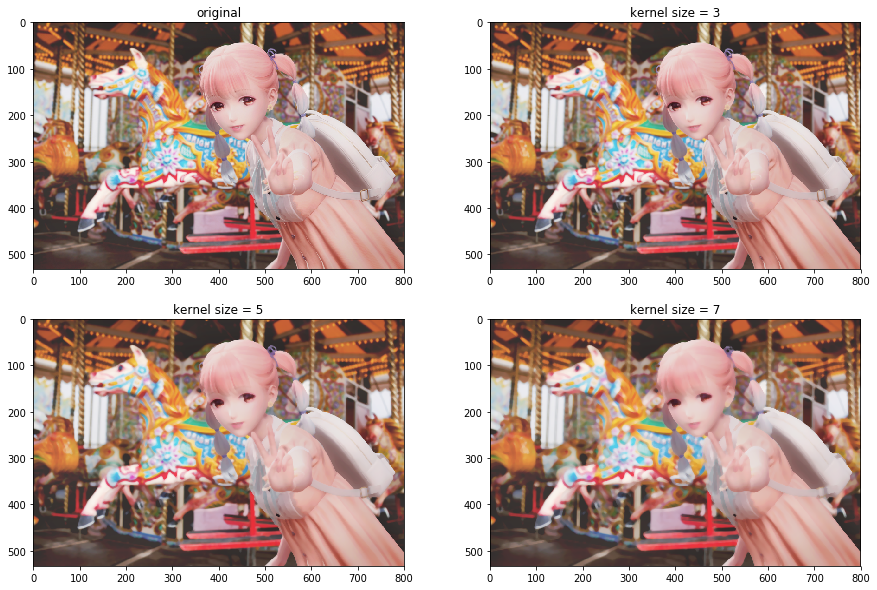

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('original')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.title('kernel size = 3')
plt.imshow(cv2.cvtColor(mb_img_3, cv2.COLOR_BGR2RGB))
plt.subplot(223)
plt.title('kernel size = 5')
plt.imshow(cv2.cvtColor(mb_img_5, cv2.COLOR_BGR2RGB))
plt.subplot(224)
plt.title('kernel size = 7')
plt.imshow(cv2.cvtColor(mb_img_7, cv2.COLOR_BGR2RGB))
plt.show()

### OpenCV还是快呀...比不了...

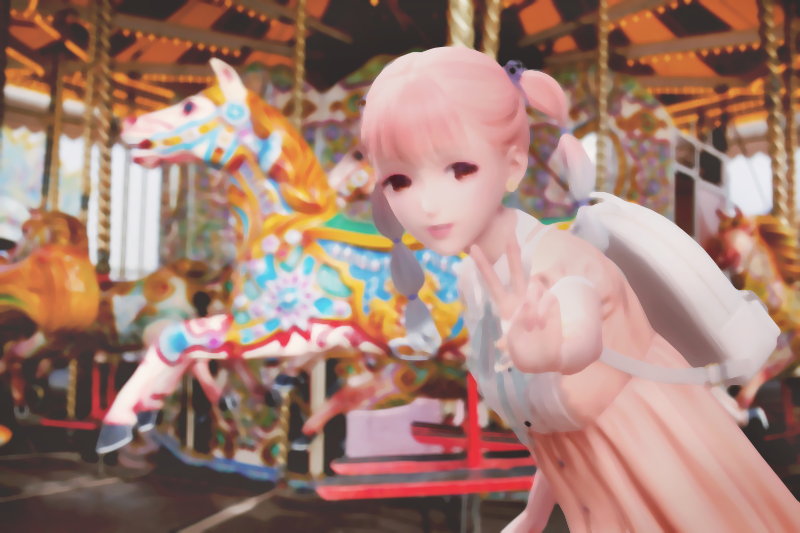

In [0]:
cv2_mb_img_7 = cv2.medianBlur(img, ksize=7)  # uses #BORDER_REPLICATE
cv2_imshow(cv2_mb_img_7)